Zihao Mao

Cameron Matson

9/22/2017

# Lab 7: CNN

## Introduction

For this lab we examine the images of the Stanford Dog Dataset.  The dataset consits of ~20,000 images of dogs from 120 different breeds.

#### Issues
The dataset is primarily used for fine-grained classification problems, meaning that the instances are all members of the same main class and are divided by subclass.  In this case, the main class is 'Dog' and the subclass is the breed: 'Beagle', 'Poodle', 'Lab'...  These are potentially more difficult than standard classification problems because in theory all members of teh main class should at least share similar features.  In other words as the saying goes "a dog is a dog is a dog not a cat."

Another challenge with this dataset is that there is that they do not depict a standard scene.  These are not faces of dogs.  These are not photoshoot photos of dogs.  The images in the dataset are not even exclusively of dogs.  Some contain multiple dogs or even people.  The dataset would benefit from preprocessing in the form of some sort of standardization such that all the images are of the same kind, using facial detection for instance.

#### Uses
Some possible uses of this type of classification: maybe a city or some other community has had a problem recently with a particular breed of dog acting violently towards humans, this system could be used on video footage (from a source like street cameras) in an attempt to identify areas where these dogs are.  Another use could be by the American Kennel Club in order to help them identify dog breeds when registering dogs without previous paperwork.  Maybe the could use the system as a preliminary step to shrink down the number of applications.  Or maybe there is an online marketplace for person to person pet sales that wants to ensure that the sellers are reliably posting the breeds that the claim.

#### Metric
In both of the cases above a high level of accuracy would be required for it to replace a human classifier.  People, especially ones who work in Animal Control or for the AKC are likely to be pretty good at identifying dogs.  Therefore to make the system as useful as possible we'd like it to have as low a false negative rate as possible, this way the human user would only be tasked with identifying false positives.  Therefore we will use recall as our metric, specifically the micro-averaged recall, because we're particularly concerned with minimizing the number of false negatives for each class.

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
%matplotlib inline
# for zihao
imagedir = '../img_data/Images'
# for cameron
#imagedir = '../../data/dogs'

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import average 
from keras.models import Input, Model
from keras.regularizers import l2

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics as mt

import numpy as np

keras.__version__

Using TensorFlow backend.


'2.0.9'

## Data Preprocessing

There are 120 different breeds included in the dataset with bout 150 images of each breed for a total of 20,580 images.  The images are stored in directories by breed.  To make the size of the dataset more managable, we're only going to select 5 particular breeds.

In [4]:
# remove dsstore
for d in os.listdir(imagedir):
    if d.find('.DS') != -1:
        os.remove(os.path.join(imagedir,d))
        continue
    for f in os.listdir(os.path.join(imagedir, d)):
        if f.find('.DS') != -1:
            os.remove(os.path.join(imagedir,d,f))
    

In [5]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(imresize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [23]:
%%time
num_breeds = 5
h=128
w=128

dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 clumber


C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1 English_setter
2 chow
3 bluetick
4 Sussex_spaniel
829
Wall time: 7.01 s


In [24]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)

enc = LabelEncoder()
y = enc.fit_transform(labels)



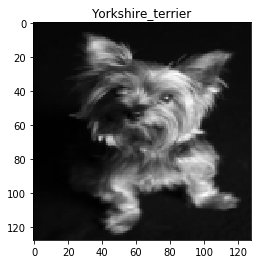

In [8]:
ex = dogs[0].reshape((h,w))
plt.imshow(ex, cmap='gray')
plt.title(labels[0])
plt.show()

Let's do a quick check of the distribution of breeds that we're using.

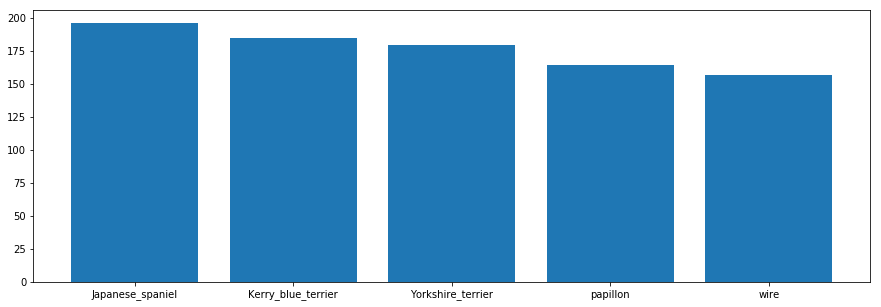

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(list(set(y)), pd.Series(y).value_counts())
plt.xticks(np.arange(5), enc.classes_)
plt.show()

As was stated previously the distribution betwewen classes is nearly uniform.

### Cross Validation Scheme

Since these networks take SOO long to train and we don't have that much data, we're  going to use a 3-fold cross-validation set up.  K-fold because we can't afford to not train on all of thee data, and 3 folds so we can finish on time.  We'll also use stratified folds to be safe even though our breed distribution is pretty uniform.  After we train the 3 models we'll be able to look at the average performance to get a sense of how the model might perform once deployed.

First we'll define 3 functions to perform three different architectures, a regular MLP, a basic CNN (a few convolutions followed by a few dense layers), and an Ensemble Net style architecture.

In [10]:
# some constants we'll need
img_hw = 128
img_wh = 128
l2_lambda = 0.001

## MLP

In [18]:
def do_mlp(X_train, y_train, X_test, y_test):
    # make a 3 layer keras MLP
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(units=30, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    mlp.fit(X_train, y_train, 
            batch_size=32, epochs=100, 
            shuffle=True, verbose=1)
    
    yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
    
    return mlp, mt.recall_score(y_test,yhat_mlp, average='micro')

## cnn1: simple

In [23]:
def do_cnn1(X_train, y_train, X_test, y_test, y_test_ohe):
    cnn_layers = [32, 16]

    # make a CNN with conv layer and max pooling
    cnn = Sequential()
    cnn.add(Reshape((1, 128, 128), input_shape=(1,128*128)))

    for n in cnn_layers:
        cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1, h,w), data_format='channels_first'))
        cnn.add(Activation('relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    # add one layer on flattened output
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())

    cnn.add(Dropout(0.25))
    cnn.add(Dense(80))
    cnn.add(Activation('relu'))

    cnn.add(Dropout(0.50))
    cnn.add(Dense(20))
    cnn.add(Activation('relu'))


    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))


    # Let's train the model 
    cnn.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn.fit(np.expand_dims(X_train, axis = 1), y_train, 
            batch_size=32, epochs=1,
            validation_data=((np.expand_dims(X_test, axis=1), y_test_ohe)),
            shuffle=True, verbose=1)
    
    yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
    
    rec = mt.recall_score(y_pred=yhat_cnn, y_true=y_test, average='micro')
    return cnn, rec

## cnn2:  Ensemble Net

In [20]:
def do_ensemble(X_train, y_train, X_test, y_test):


    num_ensembles = 3

    input_holder = Input(shape=(img_wh, img_wh, 1))

    branches = []
    for _ in range(num_ensembles):

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(input_holder)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=32,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])
    X_train = np.expand_dims(X_train.reshape(-1,img_hw,img_hw), axis=3)
    X_test = np.expand_dims(X_test.reshape(-1,img_hw,img_hw), axis=3)
    # the flow method yields batches of images indefinitely, with the given transofmrations
    cnn_ens.fit(X_train, y_train, 
            batch_size=32, epochs=20,
            shuffle=True, verbose=1)
    yhat = np.argmax(cnn_ens.predict(X_test), axis=1)
    rec = mt.recall_score(y_test,yhat, average='micro')
    
    return cnn_ens, rec

And now for the loop...

In [25]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

N_SPLITS = 2
NUM_CLASSES = 5

cnn1_rec = []
cnn2_rec = []
mlp_rec = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=False)
for train, test in skf.split(X, y):
    # split up the data
    X_train = X[train]
    y_train = y[train]
    
    X_test = X[test]
    y_test = y[test]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    # architecture 1
    print('\ntraining cnn 1')
    cnn1, cnn1_result = do_cnn1(X_train, y_train_ohe, X_test, y_test, y_test_ohe)
    cnn1_rec.append(cnn1_result)
    print('cnn1 recall score: ', cnn1_result)
    
    # architecture 2
    #print('\ntraining cnn 2')
    #cnn2, cnn2_result = do_ensemble(X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train_ohe)
    #cnn2_rec.append(cnn2_result)
    #print('cnn2 recall score: ', cnn2_result)
        
    # MLP
    print('\ntraining mlp')
    mlp, mlp_result = do_mlp(X_train, y_train_ohe, X_test, y_test)
    mlp_rec.append(mlp_result)
    print('mlp recall score: ', mlp_result)



training cnn 1
Train on 412 samples, validate on 415 samples
Epoch 1/1
412/412 [==============================] - 52s 127ms/step - loss: 0.1629 - acc: 0.2184 - val_loss: 0.1599 - val_acc: 0.2265
cnn1 recall score:  0.226506024096

training mlp
Epoch 1/100
412/412 [==============================] - 0s 1ms/step - loss: 0.2679 - acc: 0.1942
Epoch 2/100
412/412 [==============================] - 0s 487us/step - loss: 0.2101 - acc: 0.2257
Epoch 3/100
412/412 [==============================] - 0s 531us/step - loss: 0.2039 - acc: 0.2136
Epoch 4/100
412/412 [==============================] - 0s 493us/step - loss: 0.1949 - acc: 0.2063
Epoch 5/100
412/412 [==============================] - 0s 486us/step - loss: 0.1791 - acc: 0.2112
Epoch 6/100
412/412 [==============================] - 0s 525us/step - loss: 0.1718 - acc: 0.2451
Epoch 7/100
412/412 [==============================] - 0s 486us/step - loss: 0.1712 - acc: 0.2209
Epoch 8/100
412/412 [==============================] - 0s 486us/step - 

412/412 [==============================] - 0s 691us/step - loss: 0.1239 - acc: 0.5073
Epoch 81/100
412/412 [==============================] - 0s 759us/step - loss: 0.1311 - acc: 0.4709
Epoch 82/100
412/412 [==============================] - 0s 784us/step - loss: 0.1231 - acc: 0.4515
Epoch 83/100
412/412 [==============================] - 0s 683us/step - loss: 0.1216 - acc: 0.5073
Epoch 84/100
412/412 [==============================] - 0s 723us/step - loss: 0.1164 - acc: 0.5267
Epoch 85/100
412/412 [==============================] - 0s 734us/step - loss: 0.1306 - acc: 0.4733
Epoch 86/100
412/412 [==============================] - 0s 706us/step - loss: 0.1207 - acc: 0.5024
Epoch 87/100
412/412 [==============================] - 0s 685us/step - loss: 0.1269 - acc: 0.4830
Epoch 88/100
412/412 [==============================] - 0s 700us/step - loss: 0.1130 - acc: 0.5534
Epoch 89/100
412/412 [==============================] - 0s 719us/step - loss: 0.1226 - acc: 0.5121
Epoch 90/100
412/412 [=

415/415 [==============================] - 0s 532us/step - loss: 0.1190 - acc: 0.5422
Epoch 60/100
415/415 [==============================] - 0s 506us/step - loss: 0.1228 - acc: 0.5108
Epoch 61/100
415/415 [==============================] - 0s 545us/step - loss: 0.1138 - acc: 0.5614
Epoch 62/100
415/415 [==============================] - 0s 529us/step - loss: 0.1197 - acc: 0.5108
Epoch 63/100
415/415 [==============================] - 0s 714us/step - loss: 0.1145 - acc: 0.5398
Epoch 64/100
415/415 [==============================] - 0s 705us/step - loss: 0.1133 - acc: 0.5422
Epoch 65/100
415/415 [==============================] - 0s 714us/step - loss: 0.1097 - acc: 0.5807
Epoch 66/100
415/415 [==============================] - 0s 682us/step - loss: 0.1158 - acc: 0.5398
Epoch 67/100
415/415 [==============================] - 0s 674us/step - loss: 0.1084 - acc: 0.6024
Epoch 68/100
415/415 [==============================] - 0s 691us/step - loss: 0.1109 - acc: 0.5639
Epoch 69/100
415/415 [=

## so how did it do....

Below are the general statistics from the cross validation

In [26]:
print('stats:')
print('*'*6)
print('mlp:', np.mean(mlp_rec), '+-', np.std(mlp_rec))
print('cnn1:', np.mean(cnn1_rec), '+-', np.std(cnn1_rec))
#print('cnn2:', np.mean(cnn2_rec), '+-', np.std(cnn2_rec))

stats:
******
mlp: 0.297552345304 +- 0.025263188677
cnn1: 0.215194759621 +- 0.0113112644754


In [27]:
mlp_rec

[0.27228915662650605, 0.32281553398058255]

We can also look at the confusion matrix for the final instance of each of the architecture's

In [42]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    if cnn1 is not None:
        yhat_cnn1 = np.argmax(cnn1.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn1 = mt.recall_score(y_test,yhat_cnn1, average='micro')
        plt.subplot(1,3,2)
        cm = mt.confusion_matrix(y_test,yhat_cnn1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN1: '+str(rec_cnn1))
    
    if cnn2 is not None:
        yhat_cnn2 = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn2 = mt.recall_score(y_test,yhat_cnn2, average='micro')
        plt.subplot(1,3,3)
        cm = mt.confusion_matrix(y_test,yhat_cnn2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN2: '+str(rec_cnn2))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        rec_mlp = mt.recall_score(y_test,yhat_mlp, average='micro')
        plt.subplot(1,3,1)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(rec_mlp))

In [43]:
#compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc)
compare_mlp_cnn(cnn1, None, mlp, X_test, y_test, enc)

NameError: name 'cnn1' is not defined

We can also look at the ROC curve for each architecture.  Again, we'll just use the last fold, but assuming that the standard deviation on the cross-validation is small it should give a fairly good estimation. 

165/165 [==============================] - 7s 40ms/step


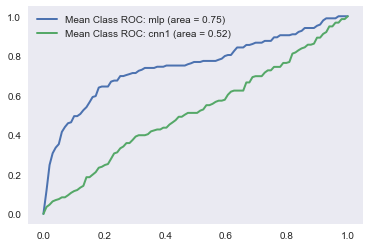

In [30]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

perclass_mean_tpr = 0.0
roc_auc = 0

# we'll just grab a random 20 % of the samples
idx = np.random.randint(0, len(X), size=int(len(X)/5))
X_hm = X[idx]
y_hm = y[idx]

probas_mlp = mlp.predict_proba(X_hm)
probas_cnn1 = cnn1.predict_proba(np.expand_dims(X_hm, axis=1))
#probas_cnn2 = cnn2.predict_proba(np.expand_dims(X_hm, axis=1))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

#for arch in ['mlp', 'cnn1', 'cnn2']:
for arch in ['mlp', 'cnn1']:
    probas = eval('probas_'+arch)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_test)
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_hm,
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,lw=2,label = 'Mean Class ROC: %s (area = %0.2f)'
                   % (arch, roc_auc))
    
plt.legend(loc='best')
plt.grid()

## With more data

Now we'll us

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [28]:
X1 = X

In [39]:
X1.shape

(829, 16384)

In [46]:
NUM_CLASSES = 5
img_hw = 128
#X = np.expand_dims(X1.reshape(-1,img_hw,img_hw), axis=1)
X = X1.reshape(-1,img_hw,img_hw)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

In [57]:
np.expand_dims(X_train, axis=3).shape

(663, 128, 128, 1)

In [62]:
cnn_layers = [32, 16]

# make a CNN with conv layer and max pooling
cnn = Sequential()

for n in cnn_layers:
    cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(h,w, 1), data_format='channels_last'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())

cnn.add(Dropout(0.25))
cnn.add(Dense(80))
cnn.add(Activation('relu'))

cnn.add(Dropout(0.50))
cnn.add(Dense(20))
cnn.add(Activation('relu'))


cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))


# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit_generator(datagen.flow(np.expand_dims(X_train, axis=3), y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=1, verbose=1,
                  validation_data=(np.expand_dims(X_test, axis=3),y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/1
6/5 [====================================] - 19s 3s/step - loss: 0.1638 - acc: 0.2121 - val_loss: 0.1598 - val_acc: 0.2349


In [68]:
compare_mlp_cnn(cnn, None, None, np.reshape(X_test, (X_test.shape[0], 1, 128*128)), y_test, enc)

ValueError: Error when checking : expected conv2d_40_input to have shape (None, 128, 128, 1) but got array with shape (166, 1, 1, 16384)

In [64]:
X_test.shape

(166, 128, 128)